In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import string
import contractions
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats
import seaborn as sns
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from scipy.stats import linregress, t
from nltk.util import ngrams

In [2]:
# Load data
df_merged = pd.read_csv(r'C:\Users\Vojimir Ranitovic\Desktop\Master CEO dataset\Topic modeling\tweets_with_topics.csv')
# Load the corpus from the text file
with open(r'C:\Users\Vojimir Ranitovic\Desktop\Master CEO dataset\corpus.txt', 'r') as file:
    corpus = file.read().splitlines()

C:\Users\Vojimir Ranitovic\AppData\Local\Temp\ipykernel_7756\1243905805.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv(r'C:\Users\Vojimir Ranitovic\Desktop\Master CEO dataset\Topic modeling\tweets_with_topics.csv')


In [4]:
# Cleaning text for word cloud
def clean_tweet_for_cloud(tweet):
    punctuation = string.punctuation + '”'
    tweet = re.sub(r'^b\'', '', tweet)
    tweet = contractions.fix(tweet)
    tweet = re.sub(r'^b(?:"|\')?(.*)$', r'\1', tweet)
    tweet = re.sub(r"\\n", ' ', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\s*\w+', '', tweet)
    tweet = re.sub(r'\\[a-z0-9]{3}', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)  # Remove non-ASCII characters
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')  # Remove non-ASCII characters
    tweet = re.sub(r'[%$^&*@#\+\/\.\-\']+', ' ', tweet)
    tweet = re.sub(r'\b\d+\b', ' ', tweet)  # Remove all numbers
    tweet = re.sub(r'\'\'\\', ' ', tweet) 
    tweet = tweet.replace('&amp', '').replace('amp', '').replace(";",'').replace(":",'') 
    tweet = re.sub(r'[\(\)\[\]\{\}<>]', ' ', tweet)
    tweet = re.sub(r'\b\d{1,2}(am|pm)\b', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.replace('"', '')
    tweet = tweet.replace("\\", "")
    
    # Lowercase
    tweet = tweet.lower()
    
    # Tokenize
    tokens = nltk.word_tokenize(tweet)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove stopwords, punctuation, and short words (except negations)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if (token not in stop_words or token in ["not", "no","non","none","neither","never","nowhere"]) and token not in punctuation and len(token) > 2]
    
    # Create trigrams
    trigrams = list(ngrams(tokens, 3))
    trigrams_with_underscore = ['_'.join(trigram) for trigram in trigrams]
    
    # Create bigrams
    bigrams = list(ngrams(tokens, 2))
    bigrams_with_underscore = ['_'.join(bigram) for bigram in bigrams]
    
    cleaned_tweet_trigrams = ' '.join(trigrams_with_underscore)
    cleaned_tweet_bigrams = ' '.join(bigrams_with_underscore)
    
    return cleaned_tweet_trigrams, cleaned_tweet_bigrams

df_merged[['cleaned_for_w_cloud_trigrams', 'cleaned_for_w_cloud_bigrams']] = df_merged['tweet'].apply(clean_tweet_for_cloud).apply(pd.Series)




In [5]:
#nltk.download('vader_lexicon')
# VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def clean_tweet_for_vader(tweet):
    punctuation = string.punctuation + '”'
    tweet = re.sub(r'^b\'', '', tweet)
    tweet = contractions.fix(tweet)
    tweet = re.sub(r'^b(?:"|\')?(.*)$', r'\1', tweet)
    tweet = re.sub(r"\\n", ' ', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\s*\w+', '', tweet)
    tweet = re.sub(r'\\[a-z0-9]{3}', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)  # Remove non-ASCII characters
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')  # Remove non-ASCII characters
    tweet = re.sub(r'[%$^&*@#\-\+\/\']+', ' ', tweet)
    tweet = re.sub(r'\b\d+\b', ' ', tweet)  # Remove all numbers
    tweet = re.sub(r'\'\'\\', ' ', tweet) 
    tweet = tweet.replace('&amp', '').replace('amp', '').replace(";",'').replace(":",'') 
    tweet = re.sub(r'[\(\)\[\]\{\}<>]', ' ', tweet)
    tweet = re.sub(r'\b\d{1,2}(am|pm)\b', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.replace('"', '')
    tweet = tweet.replace("\\", "")
    return tweet

# Preprocess and clean tweets using VADER
df_merged['clean_tweet_vader'] = df_merged['tweet'].apply(clean_tweet_for_vader)

# Calculate sentiment scores using VADER
sentiment_scores = df_merged['clean_tweet_vader'].apply(lambda x: sia.polarity_scores(x))

# Extract individual sentiment scores
df_merged['pos_vader'] = sentiment_scores.apply(lambda scores: scores['pos'])
df_merged['neu_vader'] = sentiment_scores.apply(lambda scores: scores['neu'])
df_merged['neg_vader'] = sentiment_scores.apply(lambda scores: scores['neg'])
df_merged['compound_vader'] = sentiment_scores.apply(lambda scores: scores['compound'])

df_merged['sentiment_vader'] = df_merged['compound_vader'].apply(lambda score: 'positive' if score > 0.05 else ('negative' if score < -0.05 else 'neutral'))


In [6]:
df_merged.loc[:, 'date'] = pd.to_datetime(df_merged['date'])
df_merged_copy = df_merged.copy()
tweet_counts_per_year = df_merged_copy['date'].dt.year.value_counts()
#tweet_counts_per_year

In [7]:
years_to_delete = [2007, 2008, 2023]
df_merged = df_merged[~df_merged['date'].dt.year.isin(years_to_delete)] # removing this years because there is not enough tweets

In [1]:
#df_merged.count()

# Analysis

In [2]:
# importing the final file for further analysis
#df_merged = pd.read_csv(r'C:\Users\Vojimir Ranitovic\Desktop\Master CEO dataset\SentAN bez klastera\final_file.csv')

C:\Users\Vojimir Ranitovic\AppData\Local\Temp\ipykernel_9624\48215402.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv(r'C:\Users\Vojimir Ranitovic\Desktop\Master CEO dataset\SentAN bez klastera\final_file.csv')


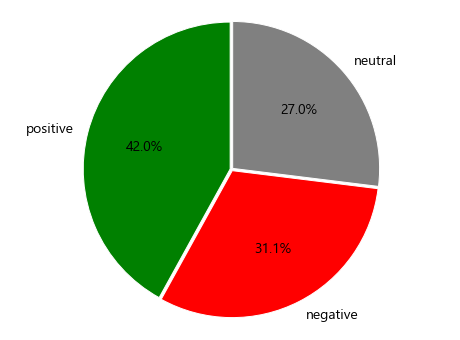

In [3]:
sentiment_counts = df_merged['sentiment_vader'].value_counts()
explode = (0.01, 0.01, 0.01)
colors = ['green', 'red', 'gray']

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', font='Segoe UI')

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
        textprops={'fontsize': 14, 'color': 'black', 'fontfamily': 'Segoe UI', 'fontweight': 'normal'})
plt.axis('equal')
plt.title('', fontsize=16)
#plt.savefig("pie.pdf", dpi=500)
plt.show()





In [152]:

df_merged['contains_link'] = df_merged['tweet'].apply(lambda x: bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)))

# Count the number of tweets that contain links
num_tweets_with_links = df_merged['contains_link'].sum()

# Calculate the percentage of tweets with links
total_tweets = len(df_merged)
percentage_with_links = (num_tweets_with_links / total_tweets) * 100

print(f"The number of tweets with links is: {num_tweets_with_links}")
print(f"The percentage of tweets with links is: {percentage_with_links}%")



The number of tweets with links is: 631384
The percentage of tweets with links is: 77.37729187321763%


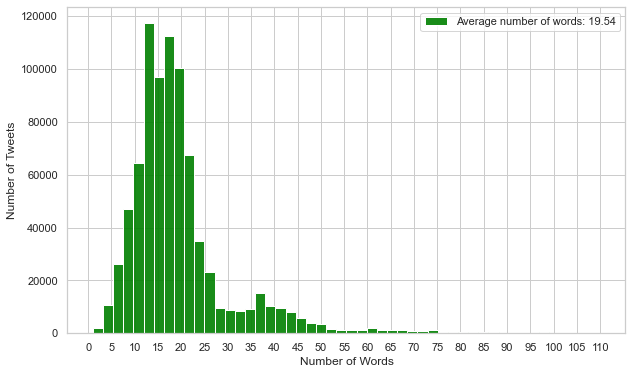

In [186]:
# Counting number of words per tweet
df_merged['word_count'] = df_merged['tweet'].apply(lambda x: len(x.split()))

# Calculate the average term count
average_word_count = df_merged['word_count'].mean()

plt.rcParams['font.family'] = 'Segoe UI'

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='word_count', color='green', bins=50, alpha=0.9)
#plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.xticks(range(0, max(df_merged['word_count'])+1, 5))
plt.legend([f'Average number of words: {average_word_count:.2f}'])
#plt.savefig("average_words.pdf", dpi=500)
plt.show()


In [147]:
# Extracting locations
locations = df_merged['location'].unique().tolist()
locations.append("")
locations.append(" ")
locations.append(None)
#locations


In [153]:
country_groups = {
    'USA': ['Austin, TX', 'Cranford, NJ', 'Dirty Jersey & West Bumblefuck', "Hilbert's Ski Resort",
            'Kansas City', 'Texas, USA', 'OKC (mostly)', 'Your Television Set via Roku', 'San Antonio, TX',
            'Minnesota', 'Cleveland, OH, USA', 'Minnesota, USA', 'Florida', 'UC Berkeley', 'Chicago, IL',
            'Garden City, NY', 'Central New York', 'Charlotte, NC', 'Toledo, Ohio', 'Texas', 'Hartford, CT',
            'Phoenix, AZ', 'Dallas, TX', 'Houston, Texas', 'Atlanta, GA, USA', 'Cambridge, Mass',
            'Horsham, West Sussex', 'Denver, CO', 'San Jose, CA', 'Oakland, CA', 'Columbus, Ohio', 'United States',
            'Brooklyn, NY', 'Long Island, New York', 'Lehigh Valley, Pa', 'Minneapolis, MN',
            'Dallas/Fort Worth, Texas', 'New Jersey, USA', 'New Haven, CT', 'Florida, USA',
            'Scotts Valley, CA 95066', 'Amherst, NY / Washington, DC', 'Greater New Haven, Connecticut',
            'Philadelphia, PA', 'Red Bank, NJ 07701', 'Jacksonville, FL', 'Columbus, OH', 'Portland, Oregon, USA',
            'Missoula, MT', 'Roanoke, VA', 'St. Louis  ', 'Salt Lake City',"USA"],
    'UK': ['London, England', 'London, UK', 'Brighton, England', 'Cardiff, Wales, UK', 'Camden County, NJ',
           'The Chichester Inn', 'Worcester, Massachusetts', 'Cheltenham', 'New Cross, London', 'Athens, London',
           'London Borough of Sutton', 'Sheffield, England', 'Swindon', 'London, United Kingdom', 'Taunton',
           'Hereford, England', 'Southampton, England', 'Liverpool, UK', 'Oxford University', 'Plymouth',
           'London, United Kingdom', 'Liverpool City Region', 'Liverpool, UK', 'Newcastle upon Tyne',
            'Wales, United Kingdom', 'Farnham, Surrey U.K.', 'England, United Kingdom',
           'Bron, France', '390  27th Street, Oakland, CA ', 'Scotland', 'England, Wales, N Ireland',
           'England, Wales, N Ireland, CI', 'University of Hull', 'England, Wales, N Ireland', 'Suffolk, UK'],
    'Canada': ['Vancouver, Canada', 'British Columbia, Canada', 'Barrie, ON', 'Ottawa, Ontario, CA',
               'Headquartered in Ottawa', 'Toronto, ON, Canada',"Canada","Canada!"],
    'Australia': ['Pacific Northwest', 'Australia', 'Perth, Western Australia', 'Sydney, Australia', 'Melbourne, Australia'],
    'Africa':['Lagos, Nigeria','Accra, Ghana',"Kenya","South Africa"],
    'Pakistan': ['Islamabad, Pakistan'],
    'India': ['India'],
    'Singapore': ['Singapore'],
    'Ireland': ['Ireland'],
    'New Zealand': ['New Zealand'],
    'Malta': ['Malta'],
    'Hong Kong': ['Hong Kong'],
    'France': ['Bron, France'],
    'Italy': ['Italy',"Italia"],
    'Norway': ['Oslo, Norway'],
    "Other": ['Dirty Jersey & West Bumblefuck', "Hilbert's Ski Resort", 'Everywhere', 'Your Television Set via Roku', 'The Bunker', 
              'Evolving', 'Worldwide', 'The Chichester Inn', 'Global', 
              'weagnosticspodcast@gmail.com', 'St. Louis', 'weagnosticspodcast@gmail.com'],
    "Empty":["nan",'',' ']

}

df_merged['country_group'] = df_merged['location'].map(
    lambda loc: next((group for group, locations in country_groups.items() if loc in locations), "Empty")
)



In [2]:
#non_empty_df

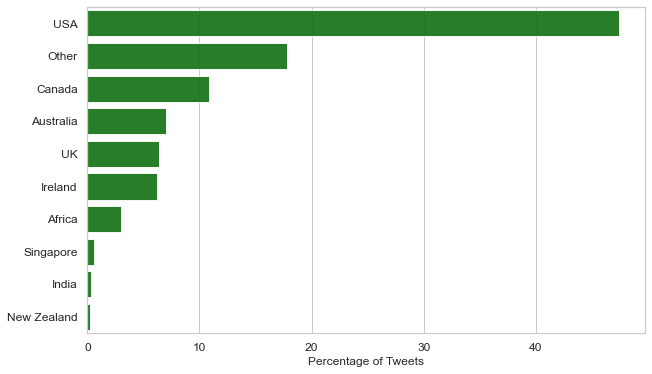

In [165]:
# Exclude empty cells from the calculation of percentages
non_empty_df = df_merged[df_merged['country_group'] != 'Empty']

# Calculate the percentage of tweets for each country group
country_group_percentages = non_empty_df['country_group'].value_counts(normalize=True) * 100

sorted_percentages = country_group_percentages.sort_values(ascending=False)

total_percentage = sorted_percentages.sum()

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_percentages.values[:10], y=sorted_percentages.index[:10], color='green',alpha=0.9)

# Set x-axis label 
plt.xlabel('Percentage of Tweets', fontsize=12)

# Set y-axis label and font size
#plt.ylabel('Country Group', fontsize=14)

# Set font size for x-axis and y-axis tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.set(font='Segoe UI')
#plt.savefig("location_graph.pdf", dpi=500)
plt.show()
#print("Sum of all country group percentages:", total_percentage)

In [3]:
#sorted_percentages

In [10]:
#df_merged.to_csv("final_file.csv")

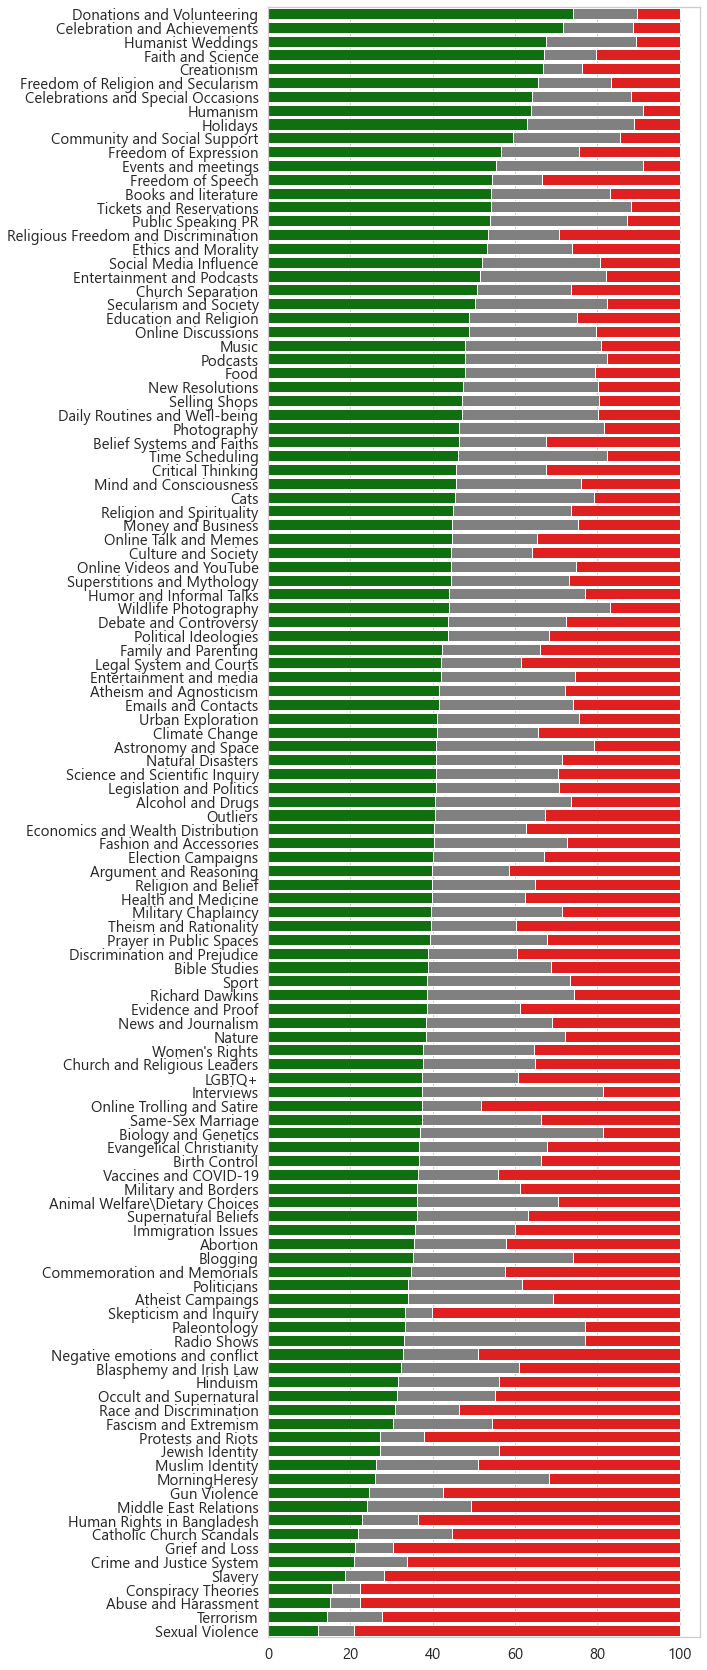

In [63]:
custom_names = df_merged["CustomName"].unique()
filtered_df = df_merged[df_merged['CustomName'].isin(custom_names)]

# Group the filtered DataFrame by CustomName and sentiment_vader labels
grouped_df = filtered_df.groupby(['CustomName', 'sentiment_vader']).size().unstack()

# Calculate the percentage of each sentiment label for each CustomName category
percentage = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100

# Sort the topics based on the positive values in descending order
percentage.sort_values(by='positive', ascending=False, inplace=True)

# Set
plt.figure(figsize=(10, 30))
font = {'fontname': 'Segoe UI', 'fontsize': 15}

# Create the stacked bar plots using seaborn
ax = sns.barplot(y=percentage.index, x=percentage['positive'], color='green')
ax = sns.barplot(y=percentage.index, x=percentage['neutral'], color='gray', left=percentage['positive'])
ax = sns.barplot(y=percentage.index, x=percentage['negative'], color='red', left=percentage['positive']+percentage['neutral'])

# Set the chart title and labels
plt.ylabel('', **font)
plt.xlabel('', **font)

# Rotate y-axis labels vertically
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Set the y-axis label font properties
plt.yticks(fontname='Segoe UI', fontsize=15)

# Set the x-axis label font properties
plt.xticks(fontname='Segoe UI', fontsize=15)

# Adjust the left margin to prevent y-label cutoff
plt.subplots_adjust(left=0.3)

# Save the figure with tight bounding box to rotate the whole graph
#plt.savefig("sentimentofall.svg", dpi=500, bbox_inches='tight')

#plt.show()



In [12]:
# Convert the 'date' column to datetime type
df_merged = df_merged.assign(date=pd.to_datetime(df_merged['date']))

# Extract the year from the 'date' column
df_merged = df_merged.assign(year=df_merged['date'].dt.year)

# Get all unique topics
unique_topics = df_merged['topic'].unique()

# List to store results
slope_table = []

# Iterate over 
for topic in unique_topics:
    # Filter the dataframe for the current topic
    filtered_df = df_merged[df_merged['topic'] == topic].copy()

    # Group the filtered data by 'year' and calculate the average compound score
    average_scores = filtered_df.groupby('year')['compound_vader'].mean().reset_index()

    # Check if the timeseries line crosses the threshold
    if (average_scores['compound_vader'] > 0.05).any() and (average_scores['compound_vader'] < -0.05).any():
        trend_change = 'Communication shift'
    elif (average_scores['compound_vader'] > 0.05).all():
        trend_change = 'Always positive communication'
    elif (average_scores['compound_vader'] < -0.05).all():
        trend_change = 'Always negative communication'
    elif(average_scores['compound_vader'] > -0.05).any() and (average_scores['compound_vader'] > 0.05).any():
        trend_change = 'Neutral-Positive'
    else:
        trend_change = "Neutral-Negative"

    # Append the topic and trend change to the result list
    slope_table.append({'Topic': topic, 'Trend Change': trend_change})

slope_df = pd.DataFrame(slope_table)

slope_df

,Topic,Trend Change
0,77,Always negative communication
1,95,Always negative communication
2,0,Neutral-Positive
3,8,Always positive communication
4,98,Communication shift
...,...,...
113,91,Neutral-Positive
114,112,Communication shift
115,113,Neutral-Positive
116,107,Neutral-Positive


In [13]:
changing_topics = slope_df[slope_df['Trend Change'] == 'Communication shift']['Topic'].tolist()
print(changing_topics)

[98, 46, 54, 14, 34, 57, 76, 49, 33, 115, 78, 87, 93, 96, 102, 97, 44, 112, 108]


In [11]:
changing_topics = slope_df[slope_df['Trend Change'] == 'Communication shift']['Topic'].tolist()
count = len(changing_topics)
print("Number of topics with 'Communication shift' trend change:", count)


Number of topics with 'Communication shift' trend change: 19


In [13]:
#df_merged.to_csv("final_file.csv")

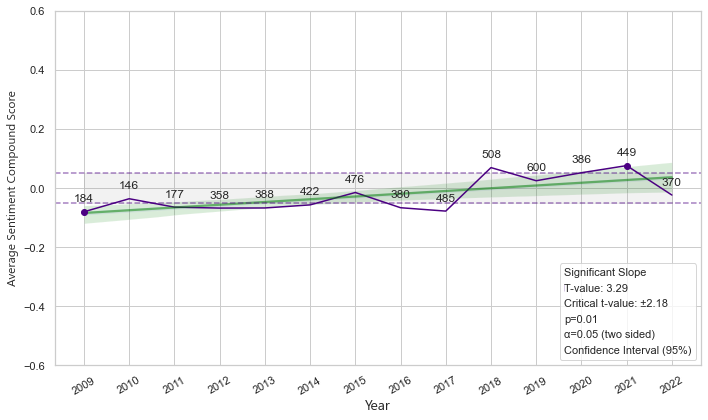

In [192]:
# Specify desired topic
desired_topic = 49

# Filter for the desired topic
filtered_df = df_merged.loc[df_merged['topic'] == desired_topic]

# Group the filtered data by 'year' and calculate the average compound score
average_scores = filtered_df.groupby('year')['compound_vader'].mean().reset_index()

# Calculate the confidence interval for the predicted values
slope, intercept, r_value, p_value, std_err = stats.linregress(average_scores['year'], average_scores['compound_vader'])
t_critical = stats.t.ppf(0.975, len(average_scores) - 2)  # alpha = 0.05, degrees of freedom = len(average_scores) - 2
x_values = average_scores['year']
predicted_values = intercept + slope * x_values
standard_error = std_err * np.sqrt(1 + 1/len(average_scores) + (x_values - average_scores['year'].mean())**2 / np.sum((average_scores['year'] - average_scores['year'].mean())**2))
confidence_interval = t_critical * standard_error

# Count the number of tweets per year
tweet_counts = filtered_df['year'].value_counts().reset_index()
tweet_counts.columns = ['year', 'tweet_count']

# Set the plot style
sns.set_style("whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average scores using seaborn
sns.lineplot(data=average_scores, x='year', y='compound_vader', ax=ax, color='indigo')
sns.regplot(data=average_scores, x='year', y='compound_vader', scatter=False, ax=ax, color='green', line_kws={'alpha': 0.5})


# Fill the confidence interval
ax.fill_between(x_values, predicted_values - confidence_interval, predicted_values + confidence_interval, alpha=0.10)

# Add horizontal lines for threshold
ax.axhline(y=0.05, color='indigo', linestyle='--', alpha=0.5)  # Line for 0.05 threshold
ax.axhline(y=-0.05, color='indigo', linestyle='--', alpha=0.5)  # Line for -0.05 threshold

# Fill between the thresholds
ax.fill_between(x_values, -0.05, 0.05, color='gray', alpha=0.10)

# Set the x-axis tick labels to display every year
ax.set_xticks(average_scores['year'])
ax.set_xticklabels(average_scores['year'], rotation=30)

# Set the axis labels and title with the specified font
font = fm.FontProperties(family='Segoe UI')
ax.set_xlabel("Year", fontproperties=font, fontsize=14)
ax.set_ylabel("Average Sentiment Compound Score", fontproperties=font, fontsize=12)
#ax.set_title("Average Compound Score per Year for {}".format(desired_topic), fontproperties=font, fontsize=14)

# Set the y-axis limits
ax.set_ylim(-0.6, 0.6)

# Annotate the tweet counts near the points
for i in range(len(tweet_counts)):
    ax.annotate(tweet_counts['tweet_count'].iloc[i],
                 (tweet_counts['year'].iloc[i], average_scores.loc[average_scores['year'] == tweet_counts['year'].iloc[i], 'compound_vader'].iloc[0]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Adjust the y-axis offset to move  labels
                 ha='center')

# Calculate the t-test
t_value = slope / std_err
is_significant = abs(t_value) > t_critical

# Mark the points of minimum and maximum
min_index = average_scores['compound_vader'].idxmin()
max_index = average_scores['compound_vader'].idxmax()
min_year = average_scores.loc[min_index, 'year']
min_score = average_scores.loc[min_index, 'compound_vader']
max_year = average_scores.loc[max_index, 'year']
max_score = average_scores.loc[max_index, 'compound_vader']
ax.plot(min_year, min_score, marker='o', markersize=6, color='indigo', label='Min')
ax.plot(max_year, max_score, marker='o', markersize=6, color='indigo', label='Max')

# legend
legend_text = []
if is_significant:
    legend_text.append("Significant Slope")
else:
    legend_text.append("Non Significant Slope")

# Add the t-score value and critical value to the legend
legend_text.append("T-value: {:.2f}".format(t_value))
legend_text.append("Critical t-value: ±{:.2f}".format(t_critical))
legend_text.append("p={:.2f}".format(p_value))
legend_text.append("α=0.05 (two sided)")
legend_text.append("Confidence Interval (95%)")
# Add the legend
ax.legend(legend_text, loc='lower right', handlelength=0, handletextpad=0)

# Adjust the layout
plt.tight_layout()
#plt.savefig("abortus_whole_graph.svg", dpi=500)
plt.show()
# two tailed test 0.025 degree of freedom 14-2

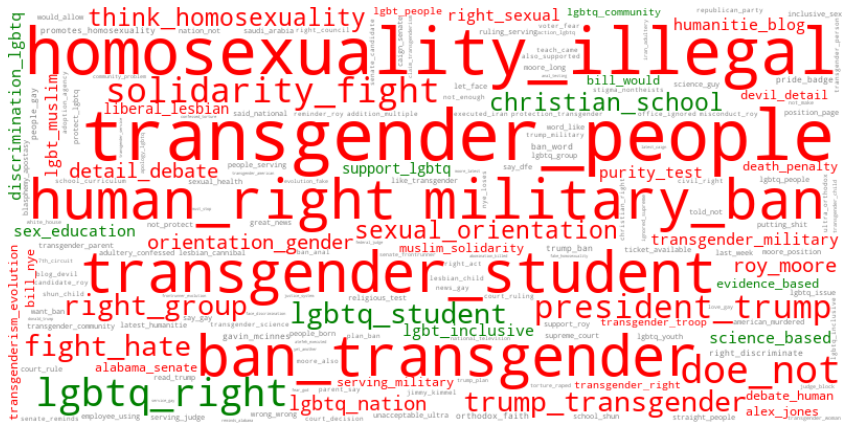

In [193]:
topic =49
start_year = 2017
end_year = 2017


# Filter the dataframe based on the topic and date range
filtered_data = df_merged[(df_merged['topic'] == topic) & (df_merged['date'].dt.year.between(start_year, end_year))]

# Filter positive and negative tweets
positive_tweets = filtered_data[filtered_data['sentiment_vader'] == 'positive']
negative_tweets = filtered_data[filtered_data['sentiment_vader'] == 'negative']
#positive_tweets = filtered_data[filtered_data['compound_vader'] >= 0.5]
#negative_tweets = filtered_data[filtered_data['compound_vader'] <=-0.5]
# Combine positive and negative words
positive_words = ' '.join(positive_tweets['cleaned_for_w_cloud_bigrams'].tolist())
negative_words = ' '.join(negative_tweets['cleaned_for_w_cloud_bigrams'].tolist())

# Calculate the sentiment scores for each word
positive_word_scores = {}
negative_word_scores = {}

for word in positive_words.split():
    if word not in positive_word_scores:
        positive_word_scores[word] = 0
    positive_word_scores[word] += 1

for word in negative_words.split():
    if word not in negative_word_scores:
        negative_word_scores[word] = 0
    negative_word_scores[word] -= 1

# Calculate the Z-scores for each word
word_scores = {word: positive_word_scores.get(word, 0) + negative_word_scores.get(word, 0)
               for word in set(positive_word_scores) | set(negative_word_scores)}

word_zscores = {word: (word_scores[word] - np.mean(list(word_scores.values()))) / np.std(list(word_scores.values()))
                for word in word_scores}

# Define the color function for the wordcloud
def color_func(word, font_size, position, orientation, random_state, **kwargs):
    if word_zscores[word] < -1.96:
        return 'red'
    elif word_zscores[word] >1.96:
        return 'green'
    else:
        return 'gray'

# Make all frequencies positive by applying absolute function
positive_word_scores = {word: abs(score) for word, score in word_scores.items()}

# Sort the positive_word_scores dictionary by frequencies in descending order
sorted_word_scores = {k: v for k, v in sorted(positive_word_scores.items(), key=lambda item: item[1], reverse=True)}

# Generate the wordcloud
wordcloud = WordCloud(background_color='white', color_func=color_func,
                      width=800, height=400).generate_from_frequencies(sorted_word_scores)

# Display the wordcloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.savefig("abortion2021-2021positive.svg", dpi=500)
plt.show()


In [33]:
sorted_word_scores

{'coronavirus_conspiracy_theory': 10,
 'tested_positive_covid-': 10,
 'tested_positive_coronavirus': 5,
 'coronavirus_resource_center': 5,
 'credit_covid_response': 4,
 'image_credit_covid': 4,
 'givingchallengeca_shapethefuture_embracehumanism': 4,
 'test_positive_covid-': 4,
 'embracehumanism_image_credit': 4,
 'shapethefuture_embracehumanism_image': 4,
 'church_tested_positive': 3,
 'selling_fake_coronavirus': 3,
 'track_covid-_pseudoscience': 3,
 'covid-_pseudoscience_snake': 3,
 'pseudoscience_snake_oil': 3,
 'positive_coronavirus_last': 3,
 'fake_coronavirus_cure': 3,
 'oil_fake_cure': 3,
 'conspiracy_theory_coronavirus': 3,
 'fake_cure_coronavirus': 3,
 'not_stop_virus': 3,
 'snake_oil_fake': 3,
 'keeping_track_covid-': 3,
 'within_twelve_hour': 2,
 'riot_dead_india': 2,
 'not_sure_well': 2,
 'coronavirus_response_effort': 2,
 'bakker_claimed_could': 2,
 'god_larger_dreaded': 2,
 'program_givingchallengeca_shapethefuture': 2,
 'covid-_distributing_rainbow': 2,
 'demonic_covid-_a

In [88]:
# Calculate the sentiment scores for each word
positive_word_scores = {}
negative_word_scores = {}

for word in positive_words.split():
    if word not in positive_word_scores:
        positive_word_scores[word] = 0
    positive_word_scores[word] += 1

for word in negative_words.split():
    if word not in negative_word_scores:
        negative_word_scores[word] = 0
    negative_word_scores[word] -= 1

# Combine positive and negative word scores
word_scores = {word: positive_word_scores.get(word, 0) + negative_word_scores.get(word, 0)
               for word in set(positive_word_scores) | set(negative_word_scores)}

# Create a DataFrame to display the frequencies and scores
word_stats = pd.DataFrame({
    'Word': list(word_scores.keys()),
    'Frequency': list(word_scores.values()),
    'Score': [word_zscores.get(word, 0) for word in word_scores.keys()]
})

# Sort the DataFrame by frequency in descending order
word_stats = word_stats.sort_values(by='Frequency', ascending=False)

# Display the table
word_stats

,Word,Frequency,Score
260,like,53,10.161993
1574,help,52,9.971531
3777,freedom,51,9.781070
7614,good,50,9.590608
5843,god,50,9.590608
...,...,...,...
2077,misinformation,-88,-16.693110
8109,people,-90,-17.074033
1290,conspiracy,-111,-21.073729
298,covid,-136,-25.835272


### If need two trends

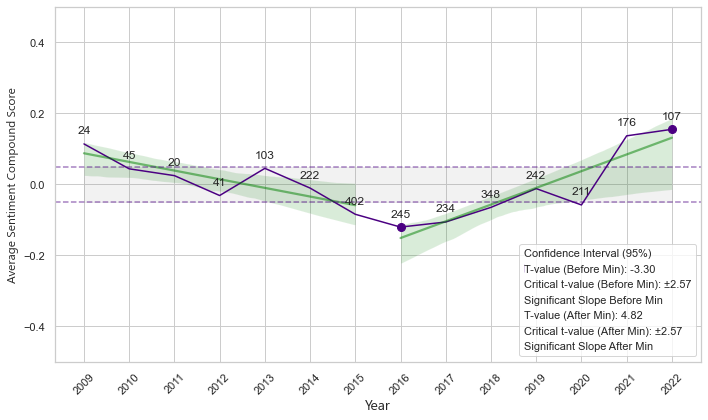

In [283]:
# Convert the 'date' column to datetime type
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Extract the year from the 'date' column
df_merged['year'] = df_merged['date'].dt.year

# Specify the desired topic
desired_topic = 98

# Filter the dataframe for the desired topic
filtered_df = df_merged[df_merged['topic'] == desired_topic]

# Group the filtered data by 'year' and calculate the average compound score
average_scores = filtered_df.groupby('year')['compound_vader'].mean().reset_index()

# Calculate the confidence interval
confidence_interval = filtered_df.groupby('year')['compound_vader'].agg(lambda x: x.sem() * 1.96).reset_index()
# 1.96 is 95% confidence interval

# Count the number of tweets per year
tweet_counts = filtered_df['year'].value_counts().reset_index()
tweet_counts.columns = ['year', 'tweet_count']

# Find the index of the minimum and maximum points
min_index = average_scores['compound_vader'].idxmin()
max_index = average_scores['compound_vader'].idxmax()

# Split the data into two subsets
before_min = average_scores[:min_index]
after_min = average_scores[min_index:]

# Set the plot style
sns.set_style("whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average scores using seaborn
sns.lineplot(data=average_scores, x='year', y='compound_vader', ax=ax, color='indigo')
sns.regplot(data=before_min, x='year', y='compound_vader', scatter=False, ax=ax, color='green', line_kws={'alpha': 0.5})
sns.regplot(data=after_min, x='year', y='compound_vader', scatter=False, ax=ax, color='green', line_kws={'alpha': 0.5})


# Add horizontal lines for threshold
ax.axhline(y=0.05, color='indigo', linestyle='--', alpha=0.5)  # Line for 0.05 threshold
ax.axhline(y=-0.05, color='indigo', linestyle='--', alpha=0.5)  # Line for -0.05 threshold
ax.fill_between(average_scores['year'], -0.05, 0.05, color='gray', alpha=0.10)
# Set the x-axis tick labels to display every year
ax.set_xticks(average_scores['year'])
ax.set_xticklabels(average_scores['year'], rotation=45)

# Set the axis labels and title with the specified font properties
font = fm.FontProperties(family='Segoe UI')
ax.set_xlabel("Year", fontproperties=font, fontsize=14)
ax.set_ylabel("Average Sentiment Compound Score", fontproperties=font, fontsize=12)
#ax.set_title("Average Compound Score per Year for {}".format(desired_topic), fontproperties=font, fontsize=14)

# Set the y-axis limits
ax.set_ylim(-0.5, 0.5)

# Annotate the tweet counts near the points
for i in range(len(tweet_counts)):
    ax.annotate(tweet_counts['tweet_count'].iloc[i],
                 (tweet_counts['year'].iloc[i], average_scores[average_scores['year'] == tweet_counts['year'].iloc[i]]['compound_vader'].iloc[0]),
                 textcoords="offset points",
                 xytext=(0, 10),  # Adjust the y-axis offset to move the labels higher
                 ha='center')

# Calculate the t-tests if the subsets are not empty
if not before_min.empty:
    slope_before, intercept_before, r_value_before, p_value_before, std_err_before = linregress(before_min['year'], before_min['compound_vader'])
    t_value_before = slope_before / std_err_before
    degrees_of_freedom_before = len(before_min) - 2
    t_critical_before = abs(t.ppf(alpha / 2, degrees_of_freedom_before))  # Two-tailed test
    if abs(t_value_before) > t_critical_before:
        significance_before = "Significant Slope Before Min"
    else:
        significance_before = "No Significant Slope Before Min"
else:
    t_value_before = 0
    significance_before = "Not Applicable"

if not after_min.empty:
    slope_after, intercept_after, r_value_after, p_value_after, std_err_after = linregress(after_min['year'], after_min['compound_vader'])
    t_value_after = slope_after / std_err_after
    degrees_of_freedom_after = len(after_min) - 2
    t_critical_after = abs(t.ppf(alpha / 2, degrees_of_freedom_after))  # Two-tailed test
    if abs(t_value_after) > t_critical_after:
        significance_after = "Significant Slope After Min"
    else:
        significance_after = "No Significant Slope After Min"
else:
    t_value_after = 0
    significance_after = "Not Applicable"

# Calculate the t-value and p-value for the entire period
slope, intercept, r_value, p_value, std_err = linregress(average_scores['year'], average_scores['compound_vader'])
t_value = slope / std_err
degrees_of_freedom_total = len(average_scores) - 2
t_critical_total = abs(t.ppf(alpha / 2, degrees_of_freedom_total))  # Two-tailed test
if abs(t_value) > t_critical_total:
    significance_total = "Significant Slope (T-test)"
else:
    significance_total = "No Significant Slope (T-test)"

# Mark the points of minimum and maximum
min_year = average_scores.loc[min_index, 'year']
min_score = average_scores.loc[min_index, 'compound_vader']
max_year = average_scores.loc[max_index, 'year']
max_score = average_scores.loc[max_index, 'compound_vader']
ax.plot(min_year, min_score, marker='o', markersize=8, color='indigo', label='Min')
ax.plot(max_year, max_score, marker='o', markersize=8, color='indigo', label='Max')

# Add the t-test results to the legend
legend_text = [
    "Confidence Interval (95%)",
    "T-value (Before Min): {:.2f}".format(t_value_before),
    "Critical t-value (Before Min): ±{:.2f}".format(t_critical_before),
    significance_before,
    "T-value (After Min): {:.2f}".format(t_value_after),
    "Critical t-value (After Min): ±{:.2f}".format(t_critical_after),
    significance_after,
]

# Add the legend with custom text
ax.legend(legend_text, loc='lower right', handlelength=0, handletextpad=0)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

#plt.savefig("refugees-two-slopes.pdf", dpi=500)
plt.show()


# User popularity -- not used in thesis

In [115]:
# Group the DataFrame by 'username'
grouped_df = df_merged.groupby('username')

# Aggregate 'likes' and 'retweets' columns by summing
popularity_scores = grouped_df[['likes', 'retweets']].sum()

# Take the first value of 'followers' column for each user
popularity_scores['followers'] = grouped_df['followers'].first()

# Calculate the average values of 'pos_vader', 'neu_vader', 'neg_vader', and 'compound_vader' for each user
popularity_scores[['pos_vader', 'neu_vader', 'neg_vader', 'compound_vader']] = grouped_df[['pos_vader', 'neu_vader', 'neg_vader', 'compound_vader']].mean()

# Count the number of tweets per username
popularity_scores['tweet_count'] = grouped_df['tweet'].count()

# Calculate user popularity score
popularity_scores['user_popularity_score'] = np.sqrt(0.25 * popularity_scores['likes'] + 0.25 * popularity_scores['retweets'] + 0.25 * popularity_scores['followers']+0.25*popularity_scores["tweet_count"])

popularity_scores = popularity_scores.reset_index()

popularity_scores.head(20)





,username,likes,retweets,followers,pos_vader,neu_vader,neg_vader,compound_vader,tweet_count,user_popularity_score
0,AAAPORG,54,22,241,0.132444,0.728556,0.138889,0.003989,9,9.027735
1,AHAustralia,546,365,1655,0.140955,0.782263,0.076779,0.127418,1527,31.988279
2,APPGhumanists,411,108,222,0.114654,0.849268,0.036078,0.285308,153,14.949916
3,ATXHAW,300,93,113,0.181267,0.802401,0.016336,0.389699,1249,20.946360
4,AXPliveshow,649,65,1919,0.108393,0.835690,0.055929,0.131132,84,26.062425
5,AfghanHumanists,187,274,408,0.147149,0.750943,0.101915,0.077935,141,15.890249
6,AmericanAtheist,441583,159595,138011,0.121796,0.807449,0.070755,0.122894,16491,434.649284
7,ApostateAfrican,16633,4053,2250,0.101499,0.791238,0.107261,-0.034901,7748,87.584245
8,AskAnAtheistWA,621,198,709,0.089906,0.855337,0.054759,0.091651,1303,26.603571
9,AthMemeStkrm,34,2,1389,0.152410,0.757344,0.090213,0.136418,61,19.274335


In [69]:
from scipy import stats
user_popularity_scores = popularity_scores['user_popularity_score']

# Apply Box-Cox transformation
transformed_scores, lambda_ = stats.boxcox(user_popularity_scores)

# Create a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the data to a 2D array
transformed_scores = transformed_scores.reshape(-1, 1)

# Scale the transformed data
scaled_scores = scaler.fit_transform(transformed_scores)

# Assign the scaled scores back to the DataFrame
popularity_scores['user_popularity_score_scaled'] = scaled_scores



In [118]:
from sklearn.preprocessing import MinMaxScaler

user_popularity_scores = popularity_scores['user_popularity_score']

# Convert to numpy 
user_popularity_scores = user_popularity_scores.to_numpy()

# Apply logarithmic transformation to the data
log_transformed_scores = np.log1p(user_popularity_scores)

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the data to a 2D array
log_transformed_scores = log_transformed_scores.reshape(-1, 1)

# Scale the logarithmically transformed data
scaled_scores = scaler.fit_transform(log_transformed_scores)

# Assign the scaled scores back to the DataFrame
popularity_scores['user_popularity_score_scaled'] = scaled_scores


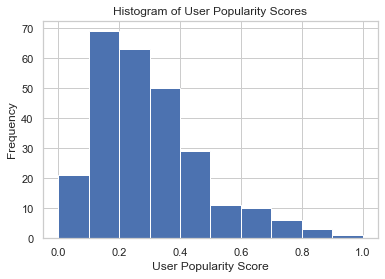

In [119]:
user_popularity_scores = popularity_scores['user_popularity_score_scaled']

# Plotting the hist
plt.hist(user_popularity_scores, bins=10)  # Adjust the number of bins as needed
plt.xlabel('User Popularity Score')
plt.ylabel('Frequency')
plt.title('Histogram of User Popularity Scores')
plt.show()


In [117]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler
scaler = RobustScaler()

# Scale the 'user_popularity_score' column
popularity_scores['user_popularity_score_scaled'] = scaler.fit_transform(popularity_scores[['user_popularity_score']])
popularity_scores

,username,likes,retweets,followers,pos_vader,neu_vader,neg_vader,compound_vader,tweet_count,user_popularity_score,user_popularity_score_scaled
0,AAAPORG,54,22,241,0.132444,0.728556,0.138889,0.003989,9,9.027735,-0.532039
1,AHAustralia,546,365,1655,0.140955,0.782263,0.076779,0.127418,1527,31.988279,0.246506
2,APPGhumanists,411,108,222,0.114654,0.849268,0.036078,0.285308,153,14.949916,-0.331230
3,ATXHAW,300,93,113,0.181267,0.802401,0.016336,0.389699,1249,20.946360,-0.127903
4,AXPliveshow,649,65,1919,0.108393,0.835690,0.055929,0.131132,84,26.062425,0.045573
...,...,...,...,...,...,...,...,...,...,...,...
258,vichumanist,1524,825,554,0.123865,0.793686,0.082443,0.110145,1509,33.211444,0.287981
259,vjack,629,321,20219,0.112754,0.773321,0.113937,0.018584,240,73.159073,1.642524
260,weagnosticspod,244,205,222,0.087477,0.859207,0.053306,0.053716,111,13.982131,-0.364046
261,whcoslo2011,12,183,326,0.110500,0.810761,0.078731,0.061107,134,12.796484,-0.404248


In [71]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(popularity_scores['user_popularity_score_scaled'], popularity_scores['compound_vader'])
# Print the correlation coefficient and p-value
print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)



Pearson correlation coefficient: -0.28957828401041913
p-value: 1.7834201332794159e-06


In [72]:
from scipy.stats import spearmanr

# Calculate the Spearman's rank 
correlation, p_value = spearmanr(popularity_scores['user_popularity_score_scaled'], popularity_scores['compound_vader'])

# Print the correlation coefficient and p-value
print("Spearman's rank correlation coefficient:", correlation)
print("p-value:", p_value)

Spearman's rank correlation coefficient: -0.31592966895101426
p-value: 1.6608378784629678e-07


C:\Users\Vojimir Ranitovic\AppData\Local\Temp\ipykernel_9432\1504228198.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=popularity_scores, x='user_popularity_score_scaled', y='compound_vader', palette='Set1', ax=ax)


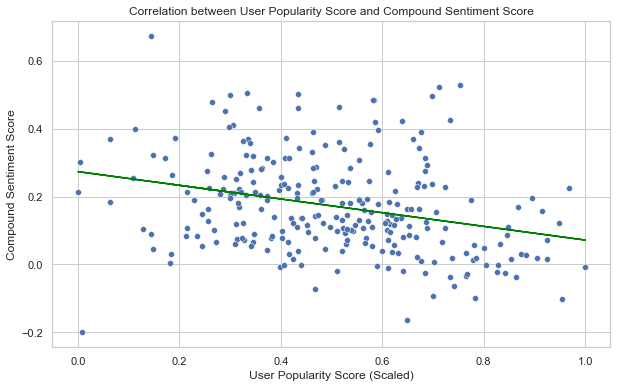

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

var1 = popularity_scores['user_popularity_score_scaled']
var2 = popularity_scores['compound_vader']

# Set the plot style
sns.set_style("whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the correlation between var1 and var2
sns.scatterplot(data=popularity_scores, x='user_popularity_score_scaled', y='compound_vader', palette='Set1', ax=ax)

# Calculate the correlation line
slope, intercept, r_value, p_value, std_err = stats.linregress(var1, var2)
correlation_line = slope * var1 + intercept

# Plot the correlation line
ax.plot(var1, correlation_line, color='green')

# Set the x-axis and y-axis labels
ax.set_xlabel('User Popularity Score (Scaled)')
ax.set_ylabel('Compound Sentiment Score')

# Set the title
ax.set_title('Correlation between User Popularity Score and Compound Sentiment Score')

# Show the plot
plt.show()
